In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class DirectTimeForecaster:
    def __init__(self, lag_count=10, forecast_horizon=10, period_length=24):
        """
        初始化预测器
        :param lag_count: 使用过去多少个时间点作为特征 (Input Window)
        :param forecast_horizon: 预测未来第几个点 (例如: 10 表示预测 t+10)
        :param period_length: 原始周期长度 (用于生成位置编码，如小时数据填24)
        """
        self.lag_count = lag_count
        self.forecast_horizon = forecast_horizon
        self.period_length = period_length
        self.model = None
        self.feature_names = []

    def prepare_data(self, df, target_col):
        """
        高效构建特征 (Vectorized implementation)
        """
        data = df.copy()
        
        # --- 1. 构建 Lag 特征 (无循环，向量化拼接) ---
        # 我们需要 t, t-1, t-2 ... t-(lag_count-1)
        # shift(0) 是当前时刻 t
        lag_features = [
            data[target_col].shift(i).rename(f'lag_{i}') 
            for i in range(self.lag_count)
        ]
        
        # --- 2. 构建 Positional Embeddings (位置编码) ---
        # 生成 0 到 period_length 的循环索引
        # 如果 df 索引是时间，也可以用 df.index.hour 等
        # 这里使用通用方法：基于行号的模运算，或者是假设数据本身是连续的
        time_idx = np.arange(len(data))
        
        # Sin/Cos 变换 (Transformer 风格)
        # 公式: sin(2 * pi * t / period)
        # 这种编码让模型理解 23点 和 0点 是紧挨着的
        pos_sin = pd.Series(np.sin(2 * np.pi * time_idx / self.period_length), name='pos_sin', index=data.index)
        pos_cos = pd.Series(np.cos(2 * np.pi * time_idx / self.period_length), name='pos_cos', index=data.index)
        
        # --- 3. 合并所有特征 ---
        # axis=1 横向拼接
        X = pd.concat(lag_features + [pos_sin, pos_cos], axis=1)
        
        # --- 4. 构建 Target (标签) ---
        # 如果我们要预测未来第 k 个点，Target 就是当前列向后移动 k 格
        # 例如 horizon=10: 当前行的特征对应的是 10 行之后的值
        y = data[target_col].shift(-self.forecast_horizon)
        
        # --- 5. 清洗数据 ---
        # 头部会有 lag_count 个 NaN (因为没有足够的历史)
        # 尾部会有 forecast_horizon 个 NaN (因为没有未来的 Target)
        valid_indices = ~(X.isna().any(axis=1) | y.isna())
        
        X = X[valid_indices]
        y = y[valid_indices]
        
        self.feature_names = X.columns.tolist()
        
        return X, y

    def train(self, df, target_col, params=None):
        """训练模型"""
        X, y = self.prepare_data(df, target_col)
        
        # 简单的按时间切分验证集 (后20%做验证)
        split_idx = int(len(X) * 0.7)
        X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]
        
        default_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 10000,
            'learning_rate': 0.05,
            'verbose': -1
        }
        if params:
            default_params.update(params)
            
        self.model = lgb.LGBMRegressor(**default_params)
        
        self.model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
        )
        print(f"Training finished. Best iteration: {self.model.best_iteration_}")

    def predict(self, current_window_df, target_col):
        """
        单点推理: 给定最近的一段历史数据，预测未来第 forecast_horizon 个点
        :param current_window_df: 必须包含最近 lag_count 行数据的 DataFrame
        """
        # 只需要取最后 lag_count 行
        if len(current_window_df) < self.lag_count:
            raise OTError(f"需要至少 {self.lag_count} 行数据才能预测")
            
        history = current_window_df.iloc[-self.lag_count:].copy()
        
        # 构造推理时的特征向量
        input_features = {}
        
        # 1. 填充 Lag 特征
        # lag_0 对应 history 的最后一行, lag_1 对应倒数第二行...
        # 注意：prepare_data 中 lag_i 是 shift(i)，所以在推理时：
        # lag_0 = OT[t] (history[-1])
        # lag_1 = OT[t-1] (history[-2])
        vals = history[target_col].values
        for i in range(self.lag_count):
            input_features[f'lag_{i}'] = [vals[-(i+1)]]
            
        # 2. 填充位置编码
        # 推理时的“当前时刻”是 history 的最后一行对应的时间
        # 我们需要计算该时刻对应的 sin/cos
        # 假设 history 索引是连续的整数或时间，这里简单演示用行号推算
        # 在实际工程中，最好传入当前具体的时间戳来计算
        current_step_idx = len(current_window_df) - 1 # 模拟当前全局索引
        
        input_features['pos_sin'] = [np.sin(2 * np.pi * current_step_idx / self.period_length)]
        input_features['pos_cos'] = [np.cos(2 * np.pi * current_step_idx / self.period_length)]
        
        # 转为 DataFrame
        input_df = pd.DataFrame(input_features)
        
        # 确保列顺序一致
        input_df = input_df[self.feature_names]
        
        return self.model.predict(input_df)[0]

# ==========================================
# 演示 Demo
# ==========================================

# 1. 生成模拟数据 (正弦波，周期=24)
data = pd.read_csv("./dataset/skippd.csv")
# 2. 配置参数
# 这里的含义是：
# 使用过去 24 个点的信息 (lag_count=24)
# 预测未来第 12 个点 (forecast_horizon=12)
# 告诉模型数据周期是 24 (period_length=24)
forecaster = DirectTimeForecaster(
    lag_count=48, 
    forecast_horizon=4, 
    period_length=24
)

# 3. 训练
print("开始训练...")
forecaster.train(data, "OT")

# 4. 推理 (测试一下)
# 取一段数据作为输入
sample_input = data.iloc[100:150] # 长度50，足够 lag_count=24 使用
pred = forecaster.predict(sample_input, 'OT')

print(f"\n--- 结果 ---")
print(f"基于输入数据截止到索引 {sample_input.index[-1]}")
print(f"预测未来第 {forecaster.forecast_horizon} 个点 (即索引 {sample_input.index[-1] + forecaster.forecast_horizon}) 的值")
print(f"预测值: {pred:.4f}")
print(f"真实值: {data['OT'].iloc[150 + 12 - 1]:.4f} (仅供验证)") 
# 注意: 索引计算仅为演示，实际根据数据结构调整

开始训练...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 2.17656
Training finished. Best iteration: 78

--- 结果 ---
基于输入数据截止到索引 149
预测未来第 4 个点 (即索引 153) 的值
预测值: 0.3654
真实值: -0.0849 (仅供验证)


In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class DirectTiledForecaster:
    def __init__(self, lag_count=5, forecast_horizon=5, period_length=24):
        self.lag_count = lag_count
        self.forecast_horizon = forecast_horizon
        self.period_length = period_length
        self.window_size = lag_count + forecast_horizon  # W = L + H
        self.model = None
        self.feature_names = []

    def prepare_data(self, df, target_col):
        """
        高效构建平铺（Tiling）特征和目标。
        """
        data = df[target_col].values
        n_samples = len(data)
        
        # 1. 计算可以创建的完整窗口数量
        num_windows = n_samples // self.window_size
        if num_windows == 0:
             raise ValueError("数据长度不足以构建一个完整窗口。")

        # 2. 截断数据以确保能被 window_size 整除
        data_tiled = data[:num_windows * self.window_size]
        
        # 3. 将一维数组重塑为二维数组 (num_windows, window_size)
        tiled_array = data_tiled.reshape(num_windows, self.window_size)
        
        # 4. 提取特征 X 和目标 y
        # X: 每行取前 lag_count 个点
        X_array = tiled_array[:, :self.lag_count]
        # y: 每行取最后一个点 (即第 L+H 个点，索引为 L+H-1)
        y_array = tiled_array[:, self.window_size - 1]
        
        # 5. 构建特征 DataFrame (使用向量化操作)
        X_df_list = []
        for i in range(self.lag_count):
            # 将每个 Lag 作为一个 Series，然后拼接 (向量化)
            series = pd.Series(X_array[:, i], name=f'lag_{self.lag_count - 1 - i}') # lag_0 是最新点
            X_df_list.append(series)

        X_final = pd.concat(X_df_list, axis=1)

        # 6. 构建 Positional Embeddings (位置编码)
        # 周期性特征必须计算 Target (y) 所在的时间点
        # Target 所在时间点相对于数据起始点的索引： i + self.window_size - 1
        
        # 找出每个窗口对应的 Target 在原始数据中的绝对索引
        # (W - 1) 是每个窗口内 Target 的偏移量
        target_abs_indices = np.arange(num_windows) * self.window_size + (self.window_size - 1)
        
        # 计算 Target 所在的周期内步长 (modulo period_length)
        target_step_idx = target_abs_indices % self.period_length
        
        X_final['pos_sin'] = np.sin(2 * np.pi * target_step_idx / self.period_length)
        X_final['pos_cos'] = np.cos(2 * np.pi * target_step_idx / self.period_length)
        
        self.feature_names = X_final.columns.tolist()
        
        # Target (y) 不需要索引，直接是 Series
        y_final = pd.Series(y_array)

        return X_final, y_final

    def train(self, df, target_col, split_ratio=0.8, params=None):
        """训练模型，并划分训练集和测试集"""
        X_all, y_all = self.prepare_data(df, target_col)
        
        # 按时间顺序切分 (前 split_ratio 训练，后 1-split_ratio 测试)
        split_idx = int(len(X_all) * split_ratio)
        
        self.X_train, self.X_test = X_all.iloc[:split_idx], X_all.iloc[split_idx:]
        self.y_train, self.y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]
        
        print(f"训练集窗口数: {len(self.X_train)}, 测试集窗口数: {len(self.X_test)}")
        # early stopping
        default_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 10000,
            'learning_rate': 0.01,
            'verbose': -1,
            
        }
        if params:
            default_params.update(params)
            
        self.model = lgb.LGBMRegressor(**default_params)
        
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
        )
        print(f"Training finished. Best iteration: {self.model.best_iteration_}")
        
    def evaluate(self):
        """在测试集上计算和返回指标"""
        if self.model is None or self.X_test is None:
            raise RuntimeError("模型尚未训练或数据尚未准备。请先调用 train 方法。")
            
        # 1. 预测
        y_pred = self.model.predict(self.X_test)
        
        # 2. 计算指标
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(self.y_test - y_pred)) # Mean Absolute Error (MAE)
        
        print("\n--- 测试集指标 ---")
        print(f"1-RMSE/Cap (均方根误差): {(1-rmse/30):.6f}")
        print(f"1-MAE/Cap (平均绝对误差): {(1-mae/30):.6f}")
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Actuals': self.y_test.values,
            'Predictions': y_pred
        }


# ==========================================
# 演示 Demo
# ==========================================


data = pd.read_csv("./dataset/Solar/Task 1/train1.csv")
print(data)
# 2. 配置参数
forecaster = DirectTiledForecaster(
    lag_count=24, 
    forecast_horizon=4, 
    period_length=96  # 假设每 24 个点一个周期
)

# 3. 训练与切分
print("开始训练...")
forecaster.train(data, 'OT', split_ratio=0.7)

# 4. 评估
results = forecaster.evaluate()
# # 可视化测试集结果
# plt.figure(figsize=(12, 6))
# plt.plot(results['Actuals'], label='Actual Target Value (Test Set)', alpha=0.7)
# plt.plot(results['Predictions'], label='Predicted Value (Test Set)', linestyle='--')
# plt.title(f'Tiled Forecasting (L={forecaster.lag_count}, H={forecaster.forecast_horizon})')
# plt.xlabel('Tiled Window Index')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

       ZONEID       TIMESTAMP        OT
0           1  20120401 01:00  0.754103
1           1  20120401 02:00  0.555000
2           1  20120401 03:00  0.438397
3           1  20120401 04:00  0.145449
4           1  20120401 05:00  0.111987
...       ...             ...       ...
26275       3  20130331 20:00  0.000000
26276       3  20130331 21:00  0.008025
26277       3  20130331 22:00  0.240075
26278       3  20130331 23:00  0.600100
26279       3  20130401 00:00  0.762425

[26280 rows x 3 columns]
开始训练...
训练集窗口数: 656, 测试集窗口数: 282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[422]	valid_0's rmse: 0.135094
Training finished. Best iteration: 422

--- 测试集指标 ---
1-RMSE/Cap (均方根误差): 0.995497
1-MAE/Cap (平均绝对误差): 0.997521


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

class SlidingWindowForecaster:
    def __init__(self, lag_count=24, forecast_horizon=4, period_length=96):
        """
        :param lag_count: 使用过去多少个点 (n)
        :param forecast_horizon: 预测未来第几个点 (k)
        :param period_length: 周期长度 (用于位置编码)
        """
        self.lag_count = lag_count
        self.forecast_horizon = forecast_horizon
        self.period_length = period_length
        self.model = None
        self.feature_names = []

    def prepare_data(self, df, target_col):
        """
        使用滑动窗口 (Sliding Window) 高效构建特征。
        利用 Pandas 的 shift 操作实现向量化，无需循环遍历行。
        """
        # 确保输入是 Series
        series = df[target_col].copy()
        
        # --- 1. 构建 Lag 特征 (X) ---
        # 我们需要 t, t-1, t-2 ... t-(lag_count-1)
        # 这里的 shift(0) 代表当前时刻 t, shift(1) 代表 t-1
        feats = []
        for i in range(self.lag_count):
            # 重命名列名为 lag_0, lag_1 ...
            # lag_0 是最近的一个点
            feat = series.shift(i)
            feat.name = f'lag_{i}'
            feats.append(feat)
            
        # --- 2. 构建 Positional Embeddings (位置编码) ---
        # 我们要预测的目标是未来时刻: t + forecast_horizon
        # 因此位置编码应该基于 (当前索引 + forecast_horizon)
        
        # 获取整数索引 (0, 1, 2...)
        time_idx = np.arange(len(series))
        
        # 计算目标时刻的索引
        target_idx = time_idx + self.forecast_horizon
        
        # 计算 Sin/Cos
        # 注意：这里直接对整列进行计算，速度极快
        pos_sin = np.sin(2 * np.pi * target_idx / self.period_length)
        pos_cos = np.cos(2 * np.pi * target_idx / self.period_length)
        
        feats.append(pd.Series(pos_sin, name='pos_sin', index=series.index))
        feats.append(pd.Series(pos_cos, name='pos_cos', index=series.index))
        
        # 合并所有特征
        X = pd.concat(feats, axis=1)
        
        # --- 3. 构建 Target (y) ---
        # 目标是未来第 k 个点，即 shift(-k)
        # 负数 shift 表示向上移动（获取未来的数据）
        y = series.shift(-self.forecast_horizon)
        y.name = 'target'
        
        # --- 4. 去除 NaN ---
        # 头部产生的 NaN (因为 lag) 和 尾部产生的 NaN (因为 target shift)
        # dropna 会自动对齐 X 和 y 的索引
        combined = pd.concat([X, y], axis=1).dropna()
        
        # 分离 X 和 y
        X_final = combined.drop(columns=['target'])
        y_final = combined['target']
        
        self.feature_names = X_final.columns.tolist()
        
        return X_final, y_final

    def train(self, df, target_col, split_ratio=0.8, params=None):
        """训练模型，并划分训练集和测试集"""
        # 1. 准备滑动窗口数据
        X_all, y_all = self.prepare_data(df, target_col)
        
        # 2. 按时间顺序切分 (不能 Shuffle)
        split_idx = int(len(X_all) * split_ratio)
        
        self.X_train, self.X_test = X_all.iloc[:split_idx], X_all.iloc[split_idx:]
        self.y_train, self.y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]
        
        print(f"数据总样本数 (Sliding): {len(X_all)}")
        print(f"训练集样本数: {len(self.X_train)}, 测试集样本数: {len(self.X_test)}")
        
        # 3. 配置 LightGBM 参数
        default_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 1000,
            'learning_rate': 0.01,
            'num_leaves': 31,     # 增加叶子节点
            'feature_fraction': 0.8, # 防止过拟合
            'verbose': -1,
            'n_jobs': -1,
            # --- 核心修改：开启 GPU 加速 ---
            'device': 'gpu',            # 指定使用 GPU
            'gpu_platform_id': 4,       # OpenCL 平台 ID (通常是 0)
            'gpu_device_id': 4,         # GPU 设备 ID (通常是 0)
            'gpu_use_dp': False,        # 是否使用双精度 (建议 False，速度更快)
        }
        if params:
            default_params.update(params)
            
        self.model = lgb.LGBMRegressor(**default_params)
        
        # 4. 训练
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50), 
                lgb.log_evaluation(period=100) # 每100轮打印一次，避免刷屏
            ]
        )
        print(f"Training finished. Best iteration: {self.model.best_iteration_}")
        
    def evaluate(self):
        """在测试集上计算和返回指标"""
        if self.model is None or self.X_test is None:
            raise RuntimeError("模型尚未训练或数据尚未准备。请先调用 train 方法。")
            
        # 1. 预测
        y_pred = self.model.predict(self.X_test)
        
        # 2. 计算指标
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(self.y_test - y_pred)) 
        
        # 防止分母为0或计算 Cap 指标 (假设 Cap=30 是你的业务常数)
        cap = 30.0
        
        print("\n--- 测试集指标 ---")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"1-RMSE/Cap: {(1 - rmse/cap):.6f}")
        print(f"1-MAE/Cap: {(1 - mae/cap):.6f}")
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Actuals': self.y_test.values,
            'Predictions': y_pred
        }

# ==========================================
# 演示 Demo
# ==========================================

# 假设你的 CSV 读取代码如下
#data = pd.read_csv("./dataset/Solar/Task 1/train1.csv")
data = pd.read_csv("./dataset/skippd.csv")
# 为了演示，我生成一段假数据
#dates = pd.date_range('2023-01-01', periods=5000, freq='15T')

# 配置参数
# lag_count=24 (过去24个点)
# forecast_horizon=4 (预测未来第4个点, 即1小时后)
# period_length=96 (一天96个点)
forecaster = SlidingWindowForecaster(
    lag_count=24, 
    forecast_horizon=4, 
    period_length=96  
)

# 训练
print("开始训练 (Sliding Window)...")
forecaster.train(data, 'OT', split_ratio=0.7)

# 评估
results = forecaster.evaluate()

开始训练 (Sliding Window)...
数据总样本数 (Sliding): 35013
训练集样本数: 24509, 测试集样本数: 10504
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.30796
[200]	valid_0's rmse: 2.27275
[300]	valid_0's rmse: 2.15268
Early stopping, best iteration is:
[319]	valid_0's rmse: 2.15005
Training finished. Best iteration: 319

--- 测试集指标 ---
MSE: 4.622719
RMSE: 2.150051
MAE: 1.100466
1-RMSE/Cap: 0.928332
1-MAE/Cap: 0.963318


In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

class SlidingWindowForecaster:
    def __init__(self, lag_count=24, forecast_horizon=4, period_length=96):
        """
        :param lag_count: 使用过去多少个点 (n)
        :param forecast_horizon: 预测未来第几个点 (k)
        :param period_length: 周期长度 (用于位置编码)
        """
        self.lag_count = lag_count
        self.forecast_horizon = forecast_horizon
        self.period_length = period_length
        self.model = None
        self.feature_names = []

    def prepare_data(self, df, target_col):
        """
        使用滑动窗口 (Sliding Window) 高效构建特征。
        利用 Pandas 的 shift 操作实现向量化，无需循环遍历行。
        """
        # 确保输入是 Series
        series = df[target_col].copy()
        
        # --- 1. 构建 Lag 特征 (X) ---
        # 我们需要 t, t-1, t-2 ... t-(lag_count-1)
        # 这里的 shift(0) 代表当前时刻 t, shift(1) 代表 t-1
        feats = []
        for i in range(self.lag_count):
            # 重命名列名为 lag_0, lag_1 ...
            # lag_0 是最近的一个点
            feat = series.shift(i)
            feat.name = f'lag_{i}'
            feats.append(feat)
            
        # --- 2. 构建 Positional Embeddings (位置编码) ---
        # 我们要预测的目标是未来时刻: t + forecast_horizon
        # 因此位置编码应该基于 (当前索引 + forecast_horizon)
        
        # 获取整数索引 (0, 1, 2...)
        time_idx = np.arange(len(series))
        
        # 计算目标时刻的索引
        target_idx = time_idx + self.forecast_horizon
        
        # 计算 Sin/Cos
        # 注意：这里直接对整列进行计算，速度极快
        pos_sin = np.sin(2 * np.pi * target_idx / self.period_length)
        pos_cos = np.cos(2 * np.pi * target_idx / self.period_length)
        
        feats.append(pd.Series(pos_sin, name='pos_sin', index=series.index))
        feats.append(pd.Series(pos_cos, name='pos_cos', index=series.index))
        
        # 合并所有特征
        X = pd.concat(feats, axis=1)
        
        # --- 3. 构建 Target (y) ---
        # 目标是未来第 k 个点，即 shift(-k)
        # 负数 shift 表示向上移动（获取未来的数据）
        y = series.shift(-self.forecast_horizon)
        y.name = 'target'
        
        # --- 4. 去除 NaN ---
        # 头部产生的 NaN (因为 lag) 和 尾部产生的 NaN (因为 target shift)
        # dropna 会自动对齐 X 和 y 的索引
        combined = pd.concat([X, y], axis=1).dropna()
        
        # 分离 X 和 y
        X_final = combined.drop(columns=['target'])
        y_final = combined['target']
        
        self.feature_names = X_final.columns.tolist()
        
        return X_final, y_final

    def train(self, df, target_col, split_ratio=0.8, params=None):
        """训练模型，并划分训练集和测试集"""
        # 1. 准备滑动窗口数据
        X_all, y_all = self.prepare_data(df, target_col)
        
        # 2. 按时间顺序切分 (不能 Shuffle)
        split_idx = int(len(X_all) * split_ratio)
        
        self.X_train, self.X_test = X_all.iloc[:split_idx], X_all.iloc[split_idx:]
        self.y_train, self.y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]
        
        print(f"数据总样本数 (Sliding): {len(X_all)}")
        print(f"训练集样本数: {len(self.X_train)}, 测试集样本数: {len(self.X_test)}")
        
        # 3. 配置 LightGBM 参数
        default_params = {
            'objective': 'regression',
            'metric': 'rmse',
            'n_estimators': 10000,
            'learning_rate': 0.01,
            'num_leaves': 31,     # 增加叶子节点
            'feature_fraction': 0.8, # 防止过拟合
            'verbose': -1,
            'n_jobs': -1,
            # --- 核心修改：开启 GPU 加速 ---
            'device': 'gpu',            # 指定使用 GPU
            'gpu_platform_id': 0,       # OpenCL 平台 ID (通常是 0)
            'gpu_device_id': 0,         # GPU 设备 ID (通常是 0)
            'gpu_use_dp': False,        # 是否使用双精度 (建议 False，速度更快)
        }
        if params:
            default_params.update(params)
            
        self.model = lgb.LGBMRegressor(**default_params)
        
        # 4. 训练
        self.model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50), 
                lgb.log_evaluation(period=100) # 每100轮打印一次，避免刷屏
            ]
        )
        print(f"Training finished. Best iteration: {self.model.best_iteration_}")
        
    def evaluate(self):
        """在测试集上计算和返回指标"""
        if self.model is None or self.X_test is None:
            raise RuntimeError("模型尚未训练或数据尚未准备。请先调用 train 方法。")
            
        # 1. 预测
        y_pred = self.model.predict(self.X_test)
        
        # 2. 计算指标
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(self.y_test - y_pred)) 
        
        # 防止分母为0或计算 Cap 指标 (假设 Cap=30 是你的业务常数)
        cap = 30.0
        
        print("\n--- 测试集指标 ---")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"1-RMSE/Cap: {(1 - rmse/cap):.6f}")
        print(f"1-MAE/Cap: {(1 - mae/cap):.6f}")
        
        return {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Actuals': self.y_test.values,
            'Predictions': y_pred
        }

# ==========================================
# 演示 Demo
# ==========================================

# 假设你的 CSV 读取代码如下
data = pd.read_csv("./dataset/Solar/Task 1/train1.csv")
# 为了演示，我生成一段假数据
#dates = pd.date_range('2023-01-01', periods=5000, freq='15T')

# 配置参数
# lag_count=24 (过去24个点)
# forecast_horizon=4 (预测未来第4个点, 即1小时后)
# period_length=96 (一天96个点)
forecaster = SlidingWindowForecaster(
    lag_count=24, 
    forecast_horizon=4, 
    period_length=96  
)

# 训练
print("开始训练 (Sliding Window)...")
forecaster.train(data, 'OT', split_ratio=0.7)

# 评估
results = forecaster.evaluate()

开始训练 (Sliding Window)...
数据总样本数 (Sliding): 26253
训练集样本数: 18377, 测试集样本数: 7876


Failed to read file: /tmp/dep-26f92b.d
Failed to read file: /tmp/dep-483e5d.d
Failed to read file: /tmp/dep-88d797.d
Failed to read file: /tmp/dep-db1fcc.d
Failed to read file: /tmp/dep-b39709.d
1 warning generated.
Failed to read file: /tmp/dep-b3fac2.d
Failed to read file: /tmp/dep-50a8ef.d
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
Failed to read file: /tmp/dep-5782e1.d
Failed to read file: /tmp/dep-abcba9.d
1 warning generated.
Failed to read file: /tmp/dep-75c0cd.d
1 warning generated.
1 warning generated.
Failed to read file: /tmp/dep-97091c.d
1 warning generated.
Failed to read file: /tmp/dep-b7d5fb.d
1 warning generated.
1 warning generated.
Failed to read file: /tmp/dep-452c70.d
Failed to read file: /tmp/dep-d1bad5.d
Failed to read file: /tmp/dep-34bf57.d
1 warning generated.
Failed to read file: /tmp/dep-cefc70.d
1 warning generated.
1 warning generated.
1 warning generated.
Failed to read file: /tmp/dep-927677.d
1 warning generated.
F

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.15733


KeyboardInterrupt: 

In [4]:
import pandas as pd

# 读取文件
df = pd.read_csv('./dataset/GEFCom/Task 15/train15.csv')

# 指定要拆分的三个 ZONE（根据 GEFCom 2014/2017 数据，通常是 Zone 1~20，但 Task 15 可能是 1,2,3）
zones = [1, 2, 3]   # 如果你的数据里是数字，也可以用 1, 2, 3（不加引号）

for zone in zones:
    subset = df[df['ZONEID'] == zone]           # 正确比较
    filename = f"zone_{zone}.csv"             # 建议文件名带 zone_ 前缀更清晰
    
    if len(subset) > 0:                       # 正确判断是否为空
        subset.to_csv(filename, index=False)
        print(f"{filename} 已保存，共 {len(subset)} 行")
    else:
        print(f"Zone {zone} 没有数据，未生成文件")

print("所有文件拆分完成！")

zone_1.csv 已保存，共 18984 行
zone_2.csv 已保存，共 18984 行
zone_3.csv 已保存，共 18984 行
所有文件拆分完成！


h      | Euler      | P-C        | RK4       
------------------------------------------
0.5    | 1.41455    | 1.43131    | 1.44876
0.2    | 1.44229    | 1.44584    | 1.44904
0.1    | 1.44657    | 1.44824    | 1.44905
0.05   | 1.44801    | 1.44885    | 1.44905


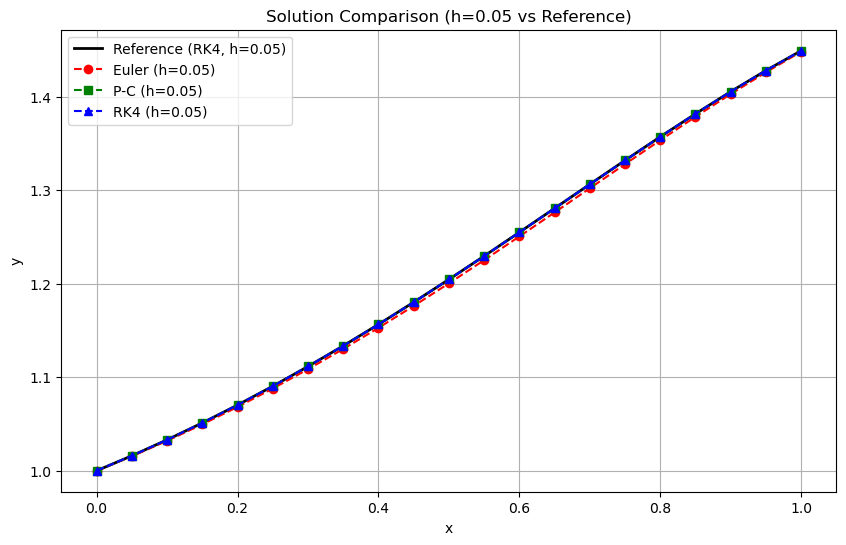

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 定义微分方程 dy/dx = f(x, y)
def f(x, y):
    return np.exp(-np.abs(x - y)) * np.sin(x * y + 1)

# 欧拉显式方法
def euler_method(h, x_end=1.0):
    steps = int(x_end / h)
    x = np.linspace(0, x_end, steps + 1)
    y = np.zeros(steps + 1)
    y[0] = 1.0  # 初始条件
    
    for i in range(steps):
        y[i+1] = y[i] + h * f(x[i], y[i])
    return x, y

# 预估-校正法 (改进欧拉/梯形法)
def predictor_corrector(h, x_end=1.0):
    steps = int(x_end / h)
    x = np.linspace(0, x_end, steps + 1)
    y = np.zeros(steps + 1)
    y[0] = 1.0
    
    for i in range(steps):
        # 预估
        y_pred = y[i] + h * f(x[i], y[i])
        # 校正
        y[i+1] = y[i] + (h / 2.0) * (f(x[i], y[i]) + f(x[i+1], y_pred))
    return x, y

# 4阶龙格-库塔法 (RK4)
def rk4_method(h, x_end=1.0):
    steps = int(x_end / h)
    x = np.linspace(0, x_end, steps + 1)
    y = np.zeros(steps + 1)
    y[0] = 1.0
    
    for i in range(steps):
        k1 = f(x[i], y[i])
        k2 = f(x[i] + h/2, y[i] + h*k1/2)
        k3 = f(x[i] + h/2, y[i] + h*k2/2)
        k4 = f(x[i] + h, y[i] + h*k3)
        
        y[i+1] = y[i] + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return x, y

# 主程序：计算并打印结果
h_values = [0.5, 0.2, 0.1, 0.05]
results = {}

print(f"{'h':<6} | {'Euler':<10} | {'P-C':<10} | {'RK4':<10}")
print("-" * 42)

for h in h_values:
    _, y_euler = euler_method(h)
    _, y_pc = predictor_corrector(h)
    _, y_rk4 = rk4_method(h)
    
    # 记录 x=1 处的最终值
    print(f"{h:<6} | {y_euler[-1]:.5f}    | {y_pc[-1]:.5f}    | {y_rk4[-1]:.5f}")

# 绘图 (可选)
plt.figure(figsize=(10, 6))
# 绘制基准线 (RK4, h=0.05)
x_ref, y_ref = rk4_method(0.05)
plt.plot(x_ref, y_ref, 'k-', linewidth=2, label='Reference (RK4, h=0.05)')

# 绘制 h=0.5 的情况进行对比
h_plot = 0.05
x_e, y_e = euler_method(h_plot)
x_pc, y_pc = predictor_corrector(h_plot)
x_rk, y_rk = rk4_method(h_plot)

plt.plot(x_e, y_e, 'r--o', label=f'Euler (h={h_plot})')
plt.plot(x_pc, y_pc, 'g--s', label=f'P-C (h={h_plot})')
plt.plot(x_rk, y_rk, 'b--^', label=f'RK4 (h={h_plot})')

plt.title(f"Solution Comparison (h={h_plot} vs Reference)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

训练集样本数: 24494, 测试集样本数: 10498
Training until validation scores don't improve for 50 rounds
[100]   valid_0's rmse: 3.13266
[200]   valid_0's rmse: 1.86893
[300]   valid_0's rmse: 1.67484
[400]   valid_0's rmse: 1.65882
Early stopping, best iteration is:
[393]   valid_0's rmse: 1.65845
Training finished. Best iteration: 393

--- 测试集指标 ---
MSE: 2.750460
RMSE: 1.658451
MAE: 0.665461
1-RMSE/Cap: 0.944718
1-MAE/Cap: 0.977818
Success for Horizon 1

Loading data...
Initializing Forecaster with: Lag=48, Horizon=16, Period=96
开始训练 (Sliding Window)...
数据总样本数 (Sliding): 34977
训练集样本数: 24483, 测试集样本数: 10494
Training until validation scores don't improve for 50 rounds
[100]   valid_0's rmse: 4.00299
[200]   valid_0's rmse: 3.26249
[300]   valid_0's rmse: 3.17602
[400]   valid_0's rmse: 3.16008
[500]   valid_0's rmse: 3.15165
Early stopping, best iteration is:
[541]   valid_0's rmse: 3.15012
Training finished. Best iteration: 541

--- 测试集指标 ---
MSE: 9.923256
RMSE: 3.150120
MAE: 1.681903
1-RMSE/Cap: 0.894996
1-MAE/Cap: 0.943937
Success for Horizon 16

Loading data...
Initializing Forecaster with: Lag=48, Horizon=96, Period=96
开始训练 (Sliding Window)...
数据总样本数 (Sliding): 34897
训练集样本数: 24427, 测试集样本数: 10470
Training until validation scores don't improve for 50 rounds
[100]   valid_0's rmse: 4.03097
[200]   valid_0's rmse: 3.19992
[300]   valid_0's rmse: 3.06555
[400]   valid_0's rmse: 3.05977
Early stopping, best iteration is:
[359]   valid_0's rmse: 3.05528
Training finished. Best iteration: 359

--- 测试集指标 ---
MSE: 9.334707
RMSE: 3.055275
MAE: 1.652020
1-RMSE/Cap: 0.898157
1-MAE/Cap: 0.944933
Success for Horizon 96